In [1]:
from sodapy import Socrata
from pathlib import Path
from urllib.request import urlopen

import json
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import geopandas as gpd
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = 'notebook'  


#   Geo file for 2015 Cencus Block Groups
#   https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2015.html#list-tab-1556094155
NYGJ = json.load(open('Data/GeoJson_NYBlockGroups_2015.json', 'rb'))

#   Constants - paths can be changed accordingly
NY_fcc_path = Path('Data/NY_fcc.csv')

In [2]:

#   If the data path doesn't exist
if not NY_fcc_path.exists():

    client = Socrata("opendata.fcc.gov", None)

    #   Querying the neccessary data through API
    #       - Limit is set to 74000000 since there is only 73.2 Mil Rows in the full dataset
    #       - Specific columns can be selected here but it is not done
    results = client.get("whue-6pnt", where="stateabbr =  'NY'", limit=74000000)

    #   Convert results into a dataframe
    NY_fcc = pd.DataFrame(results)

    #   Save the dataframe for future usage
    NY_fcc.to_csv(NY_fcc_path, index=False)

else: 

    #   Read in the previously saved dataframe (if any)
    NY_fcc = pd.read_csv(NY_fcc_path)


NY_fcc['blockgroup'] = NY_fcc['blockcode'].astype(str).str[:12].astype(str)

#   Sanity check
print(f'{len(NY_fcc.index)} rows for NY state.')


2225715 rows for NY state.


In [3]:
NY_prov_fips = NY_fcc.groupby('blockcode')['provider_id'].nunique()
NY_prov_med  = NY_prov_fips.median()

NY_fcc = NY_fcc.merge(
    NY_fcc.groupby('blockcode')['provider_id'].value_counts().reset_index(),

    on = ['blockcode', 'provider_id']
)
print(f'''
At the FIPs level the:
    - mean number of providers is {round(NY_prov_fips.mean(),2)}
    - median number of providers is {NY_prov_med}
    - number of blocks with median number of providers is {(NY_prov_fips == NY_prov_med).sum(


At the FIPs level the:
    - mean number of providers is 5.85
    - median number of providers is 6.0
    - number of blocks with median number of providers is 143225



In [4]:
NY_fcc = NY_fcc.query('maxaddown != 0 and maxadup !=0')


NY_prov_fips = NY_fcc.groupby('blockcode')['provider_id'].nunique()
NY_prov_med  = NY_prov_fips.median()

NY_fcc = NY_fcc.merge(
    NY_fcc.groupby('blockcode')['provider_id'].value_counts().reset_index(),

    on = ['blockcode', 'provider_id']
)
print(f'''
At the FIPs level the:
    - mean number of providers is {round(NY_prov_fips.mean(),2)}
    - median number of providers is {NY_prov_med}
    - number of blocks with median number of providers is {(NY_prov_fips == NY_prov_med).sum()}
''')


At the FIPs level the:
    - mean number of providers is 4.64
    - median number of providers is 5.0
    - number of blocks with median number of providers is 181847



In [27]:
NY_speeds = NY_fcc.eval('optic = (techcode == 50)').groupby(['blockgroup', 'provider_id'])[['maxaddown', 'maxadup', 'optic']].agg('max').reset_index()

/var/folders/wm/88qs1_zj7p11qlpnvf3k1kqm0000gn/T/ipykernel_5398/2386797774.py:34: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



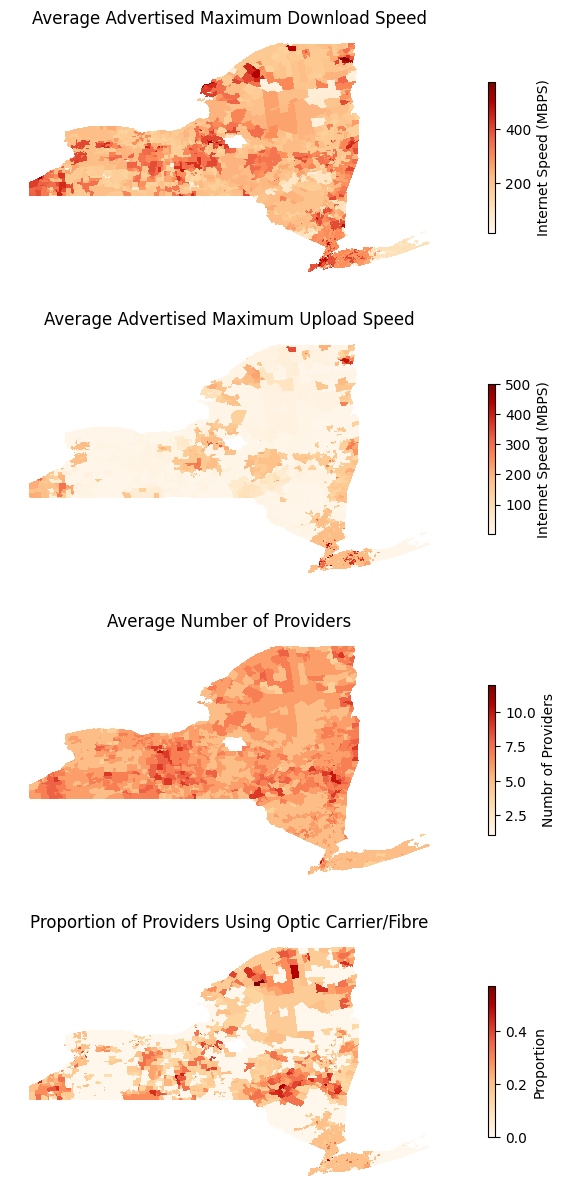

In [37]:
geo_df = gpd.GeoDataFrame.from_features(NYGJ['features'])\
    .merge(NY_speeds.groupby('blockgroup')[['maxaddown', 'maxadup', 'optic']].mean().reset_index(), left_on="GEOID", right_on="blockgroup")\
    .merge(NY_speeds.groupby('blockgroup')['provider_id'].nunique().reset_index(), left_on="GEOID", right_on="blockgroup")\
    .rename({
        'provider_id': 'nproviders',
        'maxaddown': 'avg_maxaddown',
        'maxadup': 'avg_maxadup'
    }, axis=1)\
    .set_index("GEOID")

fig, axs = plt.subplots(4, 1, figsize=(10, 15)) 

for ith, (col, lab, cap) in enumerate([
    ('avg_maxaddown',  "Internet Speed (MBPS)", 'Average Advertised Maximum Download Speed'),
    ('avg_maxadup',  "Internet Speed (MBPS)", 'Average Advertised Maximum Upload Speed'),
    ('nproviders',  "Numbr of Providers", 'Average Number of Providers'),
    ('optic', 'Proportion', "Proportion of Providers Using Optic Carrier/Fibre")
]):
    geo_df.plot(
        column=col, 
        cmap='OrRd', 
        legend=True, 
        antialiased=False,
        legend_kwds={
            "label": lab,
            'shrink': 0.6,
        },
        ax=axs[ith]
    )

    axs[ith].set_title(cap)
    axs[ith].set_axis_off()

fig.show()

In [31]:
m.OLS(geo_df['avg_maxadup'], sm.add_constant(geo_df[['nproviders', 'optic']])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            avg_maxadup   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     6237.
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:30:48   Log-Likelihood:                -89090.
No. Observations:               15362   AIC:                         1.782e+05
Df Residuals:                   15359   BIC:                         1.782e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.4295      3.434     -9.735      0.000     -40.161     -26.698
nproviders    13.8163      0.590     23.436      0.000      12.661      14.972
optic        745.3714      7.052    105.701      0.000     731.549     759.194
==============================================================================
Omnibus:                      958.331   Durbin-Watson:                   1.451
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4462.799
Skew:                           0.010   Prob(JB):                         0.00
Kurtosis:                       5.640   Cond. No.                         64.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
sm.OLS(geo_df['avg_maxaddown'], sm.add_constant(geo_df[['nproviders', 'optic']])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_maxaddown   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     6242.
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:31:11   Log-Likelihood:                -88211.
No. Observations:               15362   AIC:                         1.764e+05
Df Residuals:                   15359   BIC:                         1.765e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.6831      3.243     21.796      0.000      64.327      77.040
nproviders    26.3984      0.557     47.418      0.000      25.307      27.490
optic        632.1266      6.659     94.925      0.000     619.074     645.179
==============================================================================
Omnibus:                     1046.764   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3062.931
Skew:                          -0.356   Prob(JB):                         0.00
Kurtosis:                       5.068   Cond. No.                         64.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""